You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import NGD_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


# Load Experimental data

## select files and channels

In [48]:
cn = 41

NGD2LASpara = np.load( 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2LASpara.files:
    vars()[k] = NGD2LASpara[k][()]

NGD2LASpd = pd.DataFrame(para_dict).loc[cn-1]
NGD2LASpd

epsilon         15.068378
gamma        66078.689649
omegastar       33.593894
deltastar        0.413629
tau_y            0.019542
Dmp              4.340593
error            0.489757
Name: 40, dtype: float64

In [49]:
dt = 0.01
TKtaxis = np.arange(0, 1., dt)
TK2 = NGD2L_TK_AS(TKtaxis, *NGD2LASpd[:-1])

In [50]:
NGDASpara = np.load( 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGDASpara.npz', allow_pickle=True)
for k in NGDASpara.files:
    vars()[k] = NGDASpara[k][()]

NGDASpd = pd.DataFrame(para_dict).loc[cn-1]
NGDASpd

epsilon      15.060686
omegastar    33.679618
deltastar     0.418727
tau_y         0.019755
Bmp           4.760037
error         0.488398
Name: 40, dtype: float64

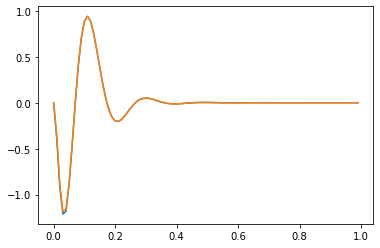

In [51]:
TK = NGD_TK_AS(TKtaxis, *NGDASpd[:-1])
plt.plot(TKtaxis, TK)
plt.plot(TKtaxis, TK2)

In [52]:
for k in NGDASpd.keys():
    vars()[k] = NGDASpd[k][()]
alpha = epsilon+omegastar*np.tan(deltastar)
beta  = epsilon-omegastar*np.tan(deltastar)
Lambda= 1/(1+beta)
g     = omegastar**2*(1+np.tan(deltastar)**2)
print('alpha:',alpha)
print('beta :',beta)
print('g    :',g)
print('lambda:',Lambda)

alpha: 30.049688766334146
beta : 0.07168350021494518
g    : 1358.9868972617035
lambda: 0.9331113148606209


In [53]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]


x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [54]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [55]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534, 0.432, 0.405, 0.395]

In [56]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

## Plot MI

In [57]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

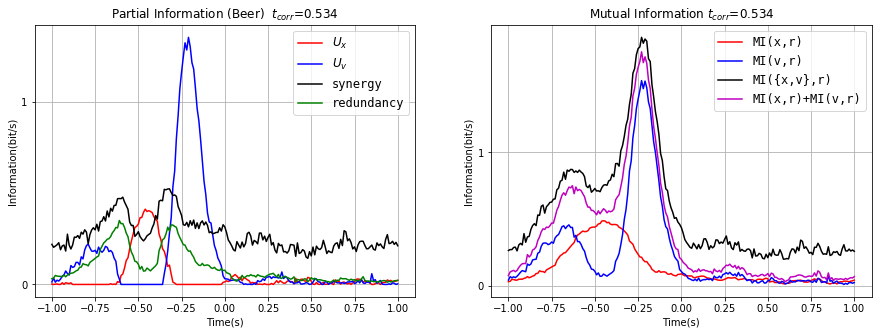

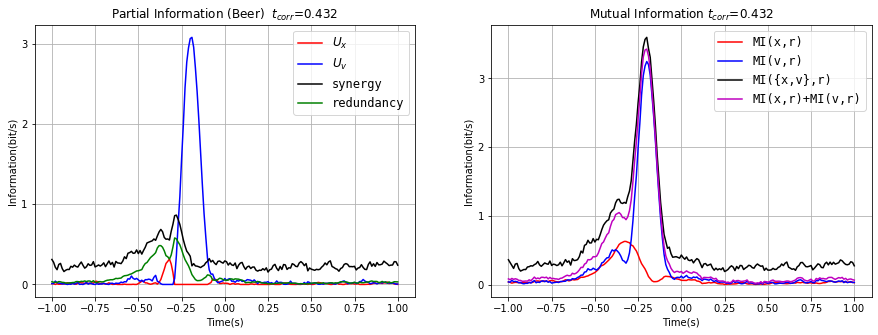

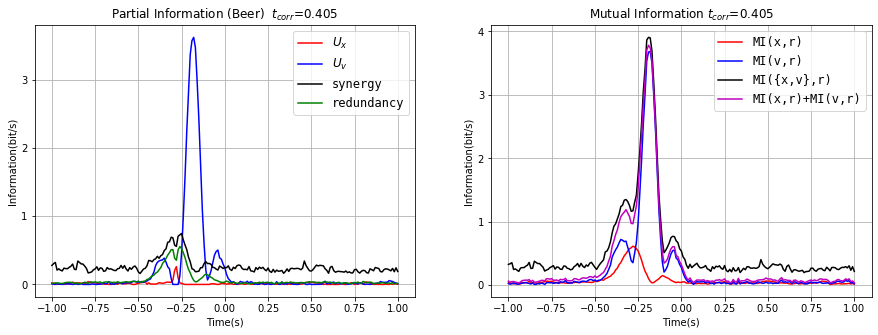

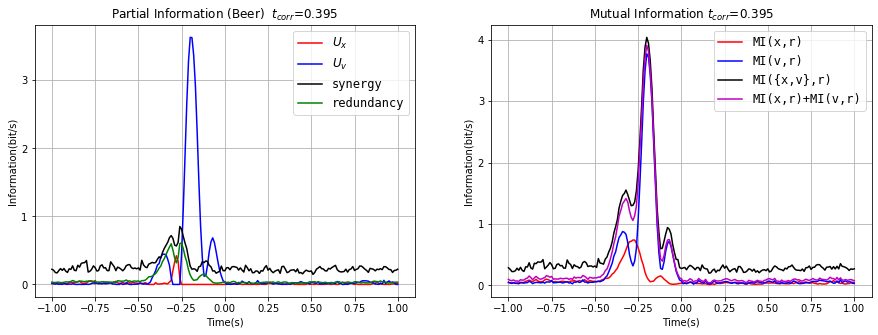

In [58]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

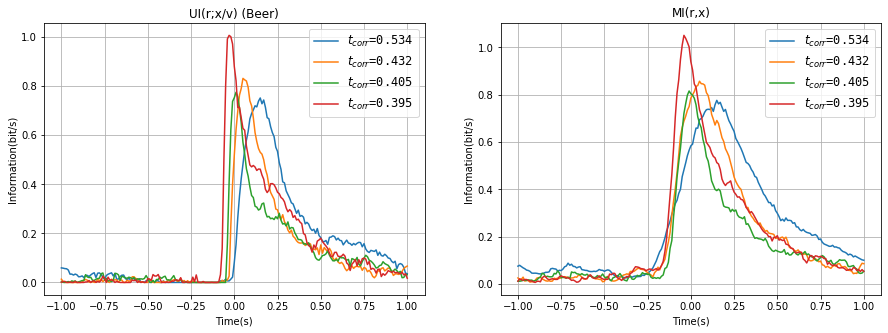

In [14]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# Matching peak height and $\Delta$

In [15]:
# Delta_list = []
# for i in range(len(x_list)):
# #     loadfiles = np.load('4PID_paper\\lambda vs. PI\\WF_PeakHeights_Fc='+str(Fc_list[i])+'.npz', allow_pickle=True)
#     loadfiles = np.load('4PID_paper\\lambda vs. PI\\WF_PeakHeightnTime_Fc.npz', allow_pickle=True)
#     for k in loadfiles.files:
#         vars()[k] = loadfiles[k][()]
#     Uvox_ratio_table = Uv_peakH/Ux_peakH
#     Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
#     delta = np.interp(Uvox_ratio, Uvox_ratio_table, Lambdas)
#     Delta_list.append(delta)
# print(Delta_list)
# Lambda_list = []

# loadfiles = np.load('4PID_paper\\beta vs. PI\\PeakHeightnTime vs Fc.npz', allow_pickle=True)
# for k in loadfiles.files:
#     vars()[k] = loadfiles[k][()]
    
# for i in range(len(x_list)-1):
#     Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
#     plt.plot(Lambdas, Uvox_ratio_table)
#     Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
#     Lambda = np.interp(Uvox_ratio, Uvox_ratio_table, Lambdas)
#     plt.scatter(Lambda, Uvox_ratio)
#     Lambda_list.append(Lambda)
# print(Lambda_list)

# Fake Spike - LC model

## parameters for LC model and Spike Generator

In [68]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
FakeSpike_list = [0]*len(x_list)
Lambda = 0.45
for i in range(len(x_list)):
    r1 = (1-Lambda)*x_list[i]+Lambda*v_list[i]
    r = NL(r1-np.mean(r1), 0)
    ratio = sum(r)/T_list[i][-1]/20
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 1)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     print(np.unique(ystate_list[i]))

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 7]


## Plot MI

In [69]:
window = [-1,1] # second
LC_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

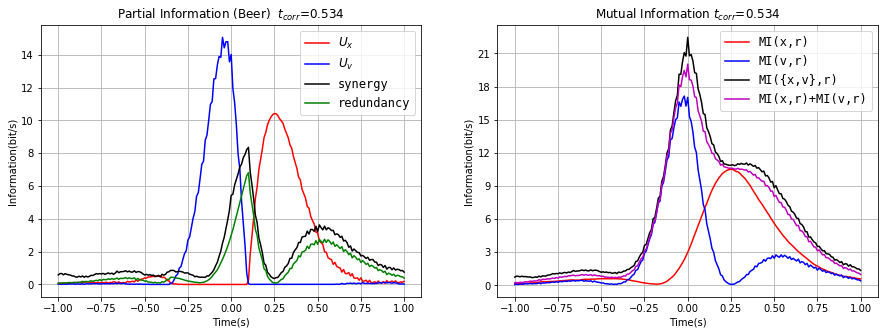

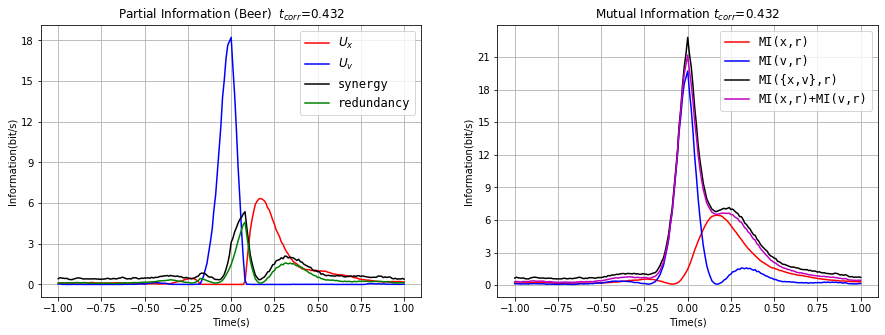

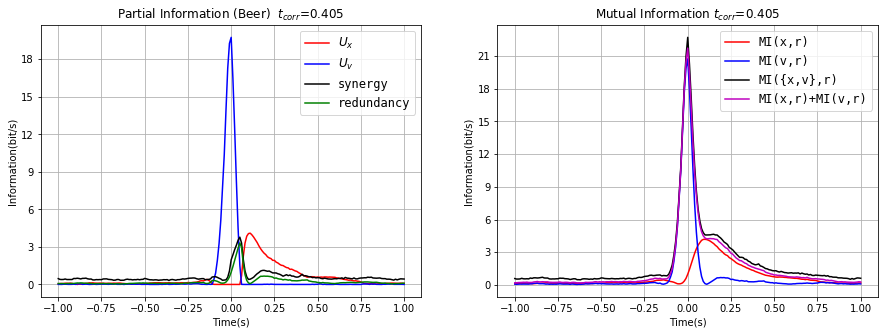

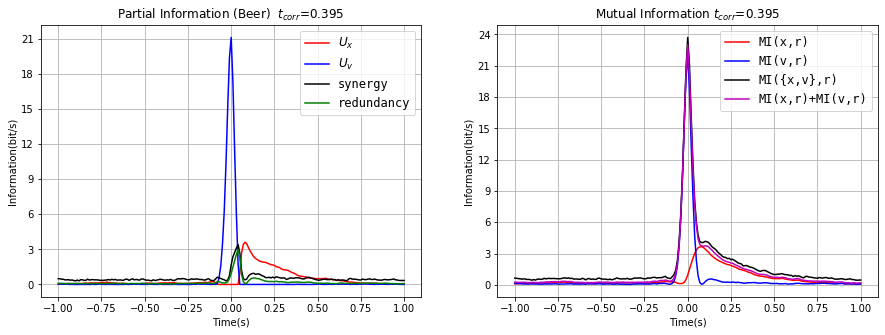

In [70]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

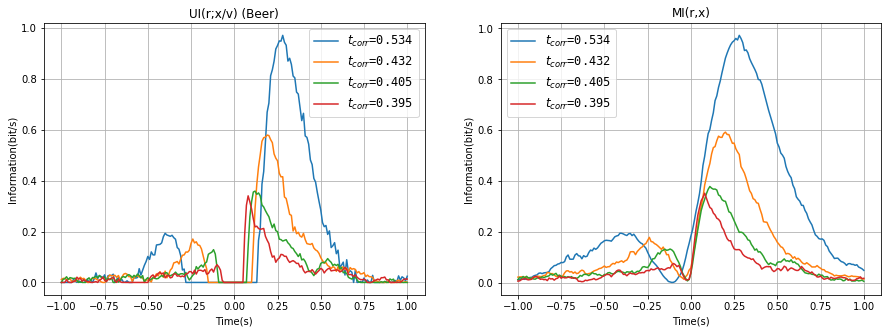

In [19]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# Fake Spike - NGD0D

## parameters for NGD model and Spike generator

In [20]:
# following paremeters match x+v*0.5s
# y_list = []
# for i in range(len(x_list)):
#     x = x_list[i].copy()
#     v = v_list[i].copy()
#     y=np.zeros(len(T_list[i]))
#     z=np.zeros(len(T_list[i]))
#     for j in range(len(T_list[i])-1):
#         dy=dt*(-alpha*y[j]+(x[j]-z[j]))
#         dz=dt*(-beta*z[j]+g*y[j])
#         y[j+1]=y[j]+dy
#         z[j+1]=z[j]+dz
#     y_list.append(y.copy())
    
def NGD_TK(T, alpha, beta, g, Amp, ds=10):
    dt = np.mean(np.diff(T))
    dt = dt/ds
    T = np.arange(0, T[-1]+dt, dt)
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    x=np.zeros(len(T))
    x[0] = 1
    for j in range(len(T)-1):
        dy = dt*(-alpha* y[j]+(x[j]-z[j]))
        dz = dt*(-beta * z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return Amp*y[::ds]/dt

T = np.arange(0,0.8,dt)
TKnd1 = NGD_TK(T, alpha, beta, g, 20, ds = 50)
y_list = [np.convolve(x, TKnd1, 'full')[:len(x)]*dt  for x in x_list]

(15000, 16000)

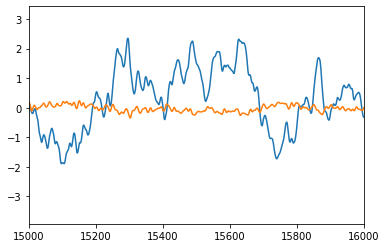

In [21]:
plt.plot(x_list[3])
plt.plot(y_list[3])
plt.xlim([15000, 16000])

Assign states

In [22]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(-y+np.mean(y), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[3 2 1 0]


## Plot STA

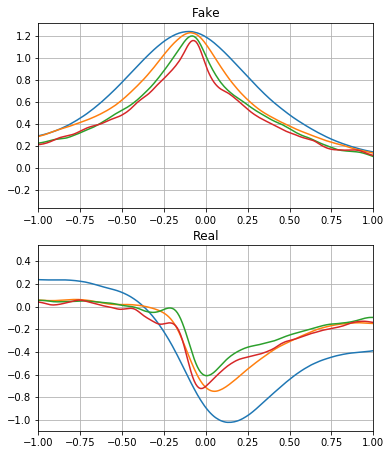

In [23]:
fig, (ax2, ax3) = plt.subplots(2,1)
for i in range(len(x_list)):
    ax2.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], ystate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), ystate_list[i], 'same'))
    ax2.set_title('Fake')
    ax3.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same'))
    ax3.set_title('Real')
for ax in (ax2, ax3): 
    ax.set_xlim([-1,1])
    ax.grid()
fig.set_size_inches(6, 7.5)

## Plot MI

In [24]:
window = [-1,1] # second
NGD_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, NGD_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = NGD_Information_list.copy()

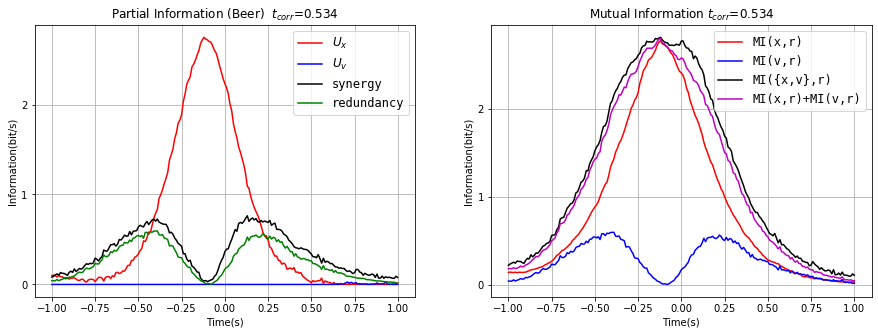

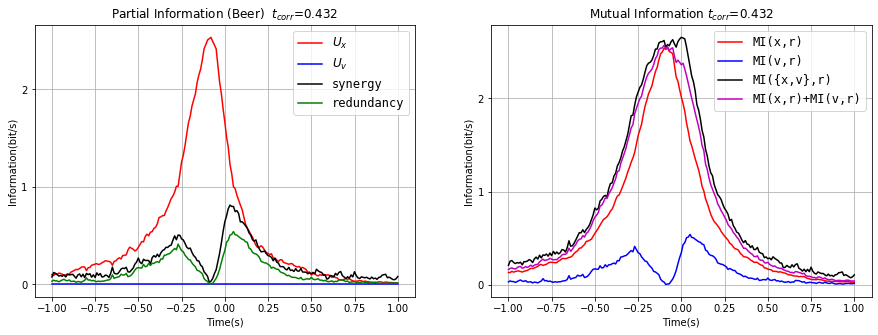

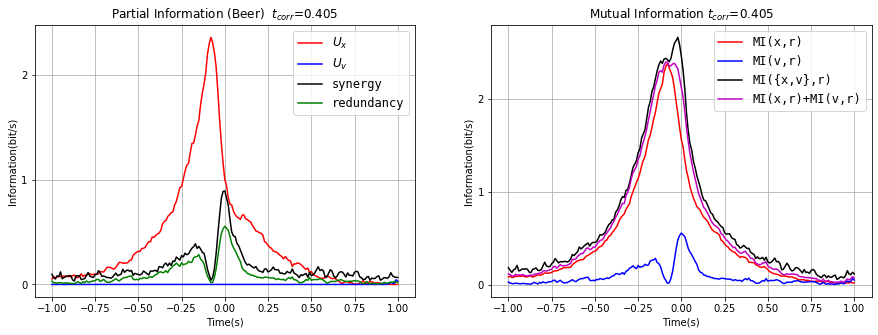

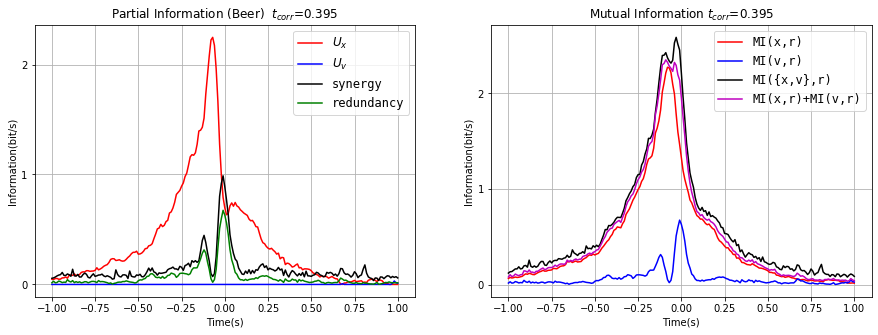

In [25]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

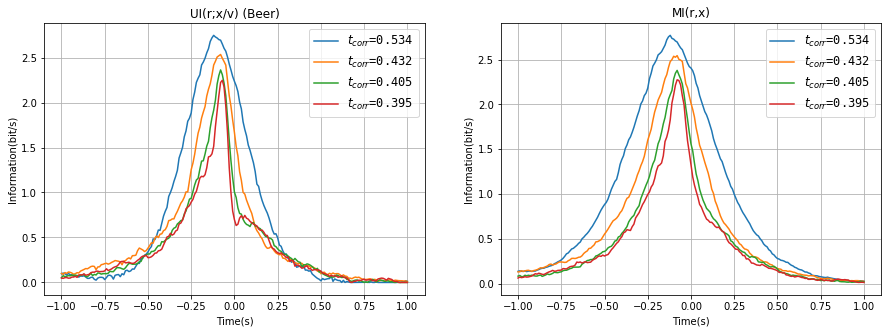

In [26]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# NGD2LAS

## parameters for NGD model and Spike generator

In [27]:
y_list = [np.convolve(x, TK, 'full')[:len(x)]*dt  for x in x_list]

(15000, 16000)

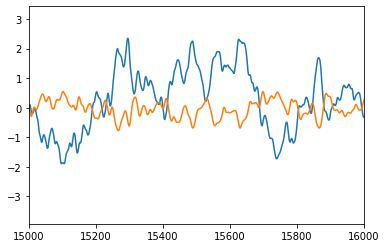

In [28]:
plt.plot(x_list[3])
plt.plot(y_list[3]*10)
# plt.plot(5*yk_list[3])
plt.xlim([15000, 16000])

Assign states

In [29]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(y-np.mean(y), 1.5*np.std(y))
    ratio = sum(r)/T_list[i][-1]/6
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[2 0 3 1]


(10000, 20000)

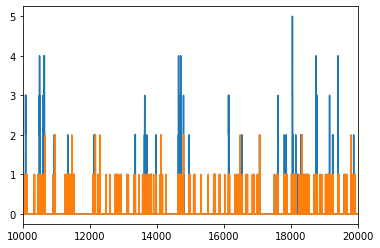

In [30]:
i = 3
plt.plot(ystate_list[i])
plt.plot(rstate_list[i])
plt.xlim([10000, 20000])

## Plot STA

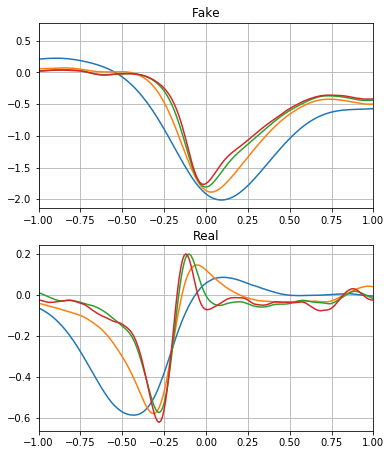

In [47]:
fig, (ax2, ax3) = plt.subplots(2,1)
for i in range(len(x_list)):
    ax2.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], ystate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), ystate_list[i], 'same'))
    ax2.set_title('Fake')
    ax3.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same'))
    ax3.set_title('Real')
for ax in (ax2, ax3): 
    ax.set_xlim([-1,1])
    ax.grid()
fig.set_size_inches(6, 7.5)

## Plot MI

In [32]:
window = [-1,1] # second
NGD_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, NGD_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = NGD_Information_list.copy()

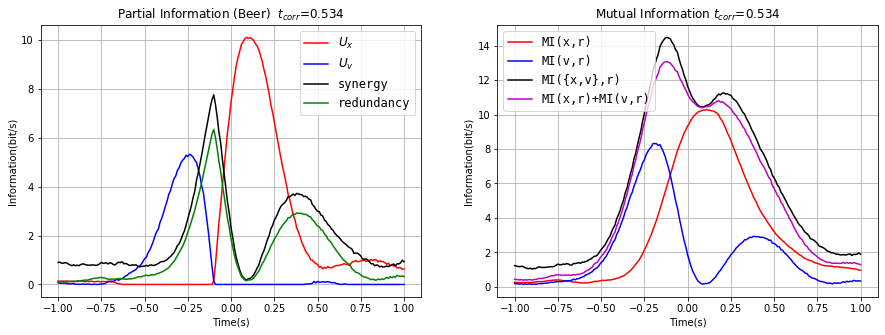

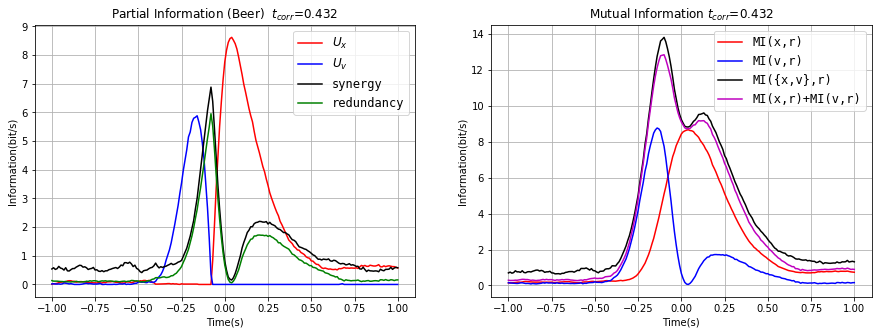

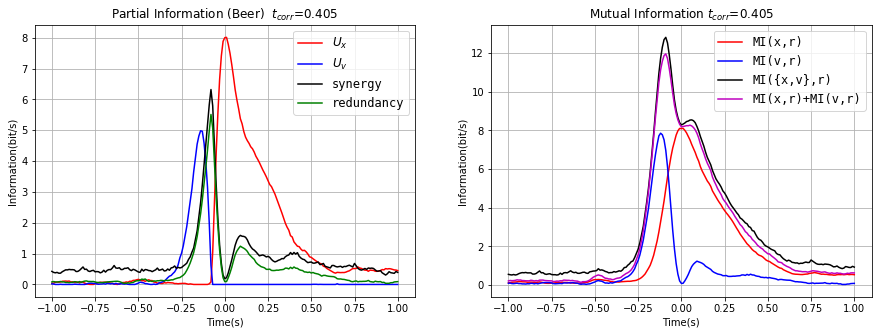

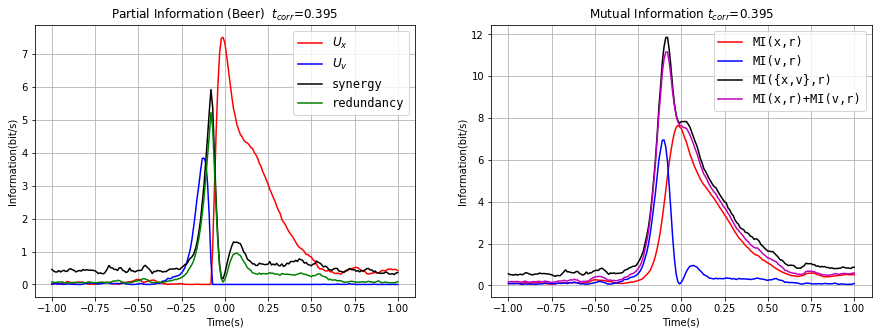

In [33]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

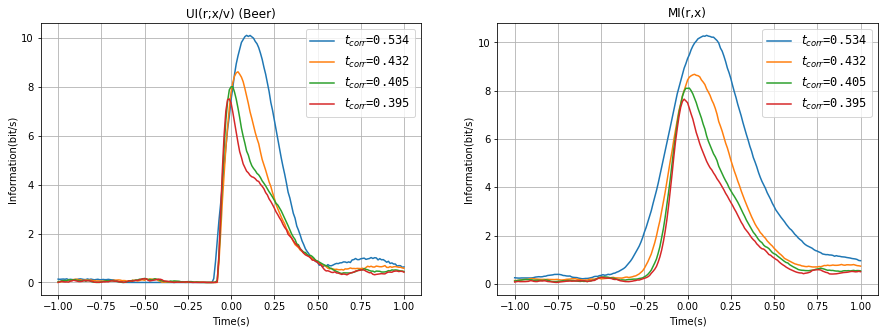

In [34]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# For Paper

In [35]:
# i = 3
# print('Fc=', Fc_list[i])
# fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
# ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
# ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
# ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
# ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.set_title('Partial Information')#+r'$t_{corr}$='+str(t_cor_list[i]))
# ax2.set_xlabel('Time (s)')
# ax2.set_ylabel('Information (bit/s)')
# ax2.legend( (r'$U_x$', r'$U_{\dotx}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# ax2.grid()

# #plot MIs
# ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
# ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
# ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
#          +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
# ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]
#          +Information_list[i][('Beer','UIv')], 'm-')
# ax3.set_title('Mutual Information ')#+r'$t_{corr}$='+str(t_cor_list[i]))
# ax3.set_xlabel('Time (s)')
# ax3.set_ylabel('Information (bit/s)')
# ax3.grid()
# ax3.legend( ('I(x,r)', r'I($\dotx$,r)', r'I({x,$\dotx$},r)', r'I(x,r)+I($\dotx$,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# fig.text(0.06,0.8, '(a)', fontsize = 20)
# fig.set_size_inches(16, 4*(np.sqrt(5)-1))

In [36]:
# fig.savefig('D:\\GoogleDrive\\retina\\PID_paper\\NP_TLPID.jpeg')

In [37]:
# import pandas as pd
# i = 3
# Information_list[i][('timeshift','timeshift')] = timeshift
# Information_list[i][('MI','I(x,r)')] = Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
# Information_list[i][('MI',r'I($\dotx$,r)')] = Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')]
# Information_list[i][('MI',r'I({x,$\dotx$},r)')] = Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')]
# Information_list[i][('MI',r'I(x,r)+I($\dotx$,r)')] = Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]
# data_df = pd.DataFrame(Information_list[i])
# # data = np.arange(1,101).reshape((10,10))
# # data_df = pd.DataFrame(data)
 
# # # change the index and column name
# # data_df.columns = ['A','B','C','D','E','F','G','H','I','J']
# # data_df.index = ['a','b','c','d','e','f','g','h','i','j']
 
# # create and writer pd.DataFrame to excel
# name  = 'ModelMIPI_5Hz'
# writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# data_df.to_excel(writer,'page_1',float_format='%.5f') # float_format 控制精度
# writer.save()